<a href="https://colab.research.google.com/github/AllenInstitute/EducationAndEngagement/blob/main/1_Tuning_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h3> This notebook walks us through how to compute a tuning curve using the Allen Brain Observatory data </h3>
    
A tuning curve summarizes a neuron's response to stimulus categories. Here we will look at the responses of a neuron to the 'Drifting Gratings' stimulus.

The Drifting Gratings stimulus consists of a sinusoidal grating that moves in 8 directions and at 5 temporal frequencies. Each stimulus condition (direction + temporal frequency combination) is repeated 15 times in random order. In addition, there are blanksweeps (when the grating is replaced with mean luminance gray) interleaved among the trials.

We will compute the mean response of a neuron to each of these stimulus conditions.

In [ ]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }
# run only once per runtime/session, and only if running in colab
# the runtime will need to restart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

### Standard imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Allen Brain Observatory set up

This instantiates the tools in the Allen SDK that allow us to access the Brain Observatory data.

In [ ]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '/data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

We'll look at one cell to start

In [ ]:
cell_id = 541513979

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>In order to compute the tuning curve of the neuron, we need to access

<li>the activity of the neuron.  We will use the DF/F trace
<li>stimulus information for the drifting grating stimulus

<p>We have written the function below that uses the AllenSDK to get these pieces of data. It does so by first identifying which experiment session contains the specified cell id and stimulus. It then accesses the NWB file for that session and reads the DF/F trace for the specified cell and the stimulus table for the specified stimulus.
</div>

In [ ]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus):
    #identify the session for a given cell id and stimulus
    exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])

    #get the session_id for that session
    session_id = exps[0]['id']

    #access the data for that session
    data_set = boc.get_ophys_experiment_data(session_id)

    #get the DFF trace for the cell
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]

    #get the stimulus table for the stimulus
    stim_table = data_set.get_stimulus_table(stimulus)

    #return everything
    return (timestamps, dff_trace, stim_table)

In [ ]:
timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

It is always good to look at the data objects you're working with to make sure you understand what they are.

In [ ]:
dff_trace.shape

(115741,)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Plot the DF/F trace of our neuron to see what it looks like
</div>

Text(0, 0.5, 'DFF')

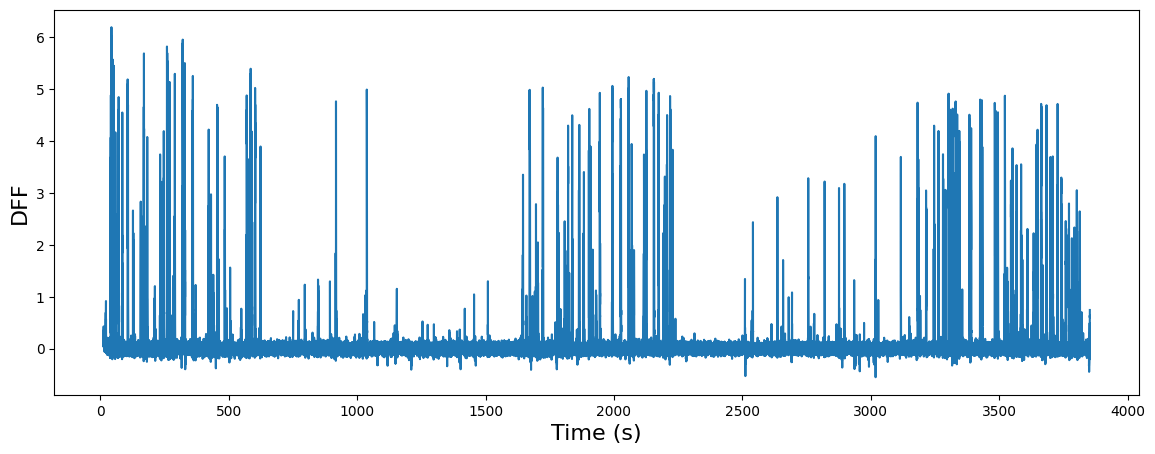

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(timestamps, dff_trace)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("DFF", fontsize=16)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Now look at our stimulus table to see what information we have. This is a pandas DataFrame, and for now we just want to see the first few lines to understand what the structure is, so use the function <b>head</b> to see the top of this DataFrame.
</div>

In [ ]:
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The stimulus table has 5 columns.  Start and end indicate the <b>frame number</b> when a given grating condition starts and ends, respectively. The other columns indicate what the grating codition is, including the temporal frequency of the grating (in Hz), the direction (called orientation) of the grating (in degrees), and whether the grating is a blank sweep (eg. a gray screen).
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
Task: How many unique temporal frequencies and orientations are there in this stimulus? Print the unique values for each of these parameters.
</div>

In [ ]:
#@title Click to see solution {display-mode: "form" }
print(stim_table.temporal_frequency.unique())
print(stim_table.orientation.unique())

array([ 1., 15., nan,  4.,  2.,  8.], dtype=float32)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
To look at the cell's response to a given grating presentation, let's plot the DF/F of the cell during the presentation of that grating.  We want to pad the plot with ~ 1 second of the DF/F trace preceding the grating presentation.  1 second = 30 frames.  We'll plot the response to the first grating presentation.
<div>

Text(0.5, 0, 'Frames')

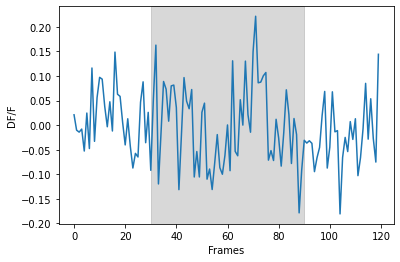

In [ ]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

We want to quantify this response. We can explore different methods of quantifying this.
* mean DF/F during the grating presentation
* sum of the DF/F during the grating presentation (are these different?)
* maximum DF/F during grating

For now let's use the mean DF/F during the presentation of the grating.

In [ ]:
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

-0.0020014683

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 1:** Repeat this for the next grating stimulus: plot the next trial and calculate the mean DF/F.</div>

Text(0.5, 0, 'Frames')

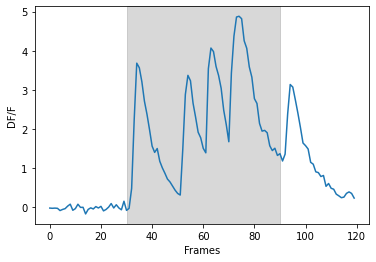

In [ ]:
#@title Click to see solution {display-mode: "form" }
plt.plot(dff_trace[stim_table.start[1]-30:stim_table.end[1]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

In [ ]:
#@title Click to see solution {display-mode: "form" }
dff_trace[stim_table.start[1]:stim_table.end[1]].mean()

NameError: name 'dff_trace' is not defined

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Already we can see that some stimulus conditions elicit larger responses than others.  This is what we want to quantify.

<p><p>To do this, let's calculate the mean DF/F for each grating presentation in this stimulus. To start, let's create a numpy array to hold our calculated responses for each trials. We'll have three columns, one for the stimulus orientation, one for the stimulus temporal frequency, and the last for the cell's response. Then we need to iterate over all stimulus trials, populate the orientation and TF and then calculate the mean response.
    
</div>

In [ ]:
cell_response= np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.orientation[i]
    cell_response[i,1] = stim_table.temporal_frequency[i]
    cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
If we only care about one stimulus parameter, we can quickly compare the response to that parameter, say the direction. Here we will plot each grating response as a function of the grating orientation.
</div>

Text(0, 0.5, 'Mean DF/F')

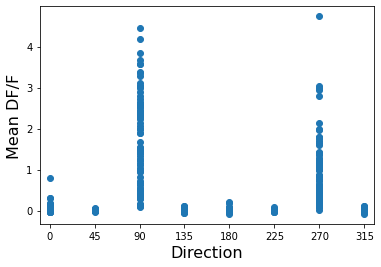

In [ ]:
plt.plot(cell_response[:,0], cell_response[:,2], 'o')
plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
What do we see?
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 2:** Repeat this for the temporal frequency parameter </div>

Text(0, 0.5, 'Mean DF/F')

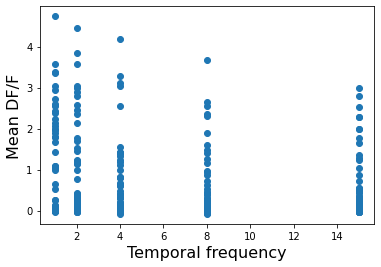

In [ ]:
plt.plot(cell_response[:,1], cell_response[:,2], 'o')
plt.xlabel("Temporal frequency", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We want to quantify this more explicitly.  So let's average all of the responses to each orientation together. This is the mean DF/F response to an orientation, for all temporal frequencies, for all trials.  For example, for orientation=270:
</div>

In [ ]:
trials = cell_response[:,0]==270 #Find the trials where the orientation is 270
cell_response[trials,2].mean() #Average the mean DF/F of just those trials together

0.9247032543023427

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>Let's compute and plot the mean response as a function of orientation (averaged across all temporal frequencies).
    
<p> To start, we need to know what all the possible orientation values are. We need to identify the <b>unique</b> values that are not NaNs (e.g. values that are <b>finite</b>)
</div>

In [ ]:
all_ori = np.unique(cell_response[:,0])
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

[  0.  45.  90. 135. 180. 225. 270. 315.]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>Now let's make an array with the average response of all trials for each of these orientations.
    
<p> We can use <b>enumerate</b> to iterate over the orientations in our list. Let me show you the syntax for enumerate. It iterates across the object and returns both the iterator (i.e. the index) and the value for each iteration.

<p> Always remember that if you don't understand a python function you can use ? to get the docstring to help you understand it.</div>

In [ ]:
? enumerate

In [ ]:
for i, ori in enumerate(orivals):
    print(i, ori)

0 0.0
1 45.0
2 90.0
3 135.0
4 180.0
5 225.0
6 270.0
7 315.0


In [ ]:
tuning = np.empty((8))
for i, ori in enumerate(orivals):
    trials = cell_response[:,0]==ori
    tuning[i] = cell_response[trials,2].mean()

Text(0, 0.5, 'Mean DF/F')

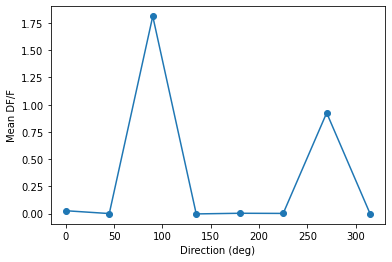

In [ ]:
plt.plot(orivals, tuning, 'o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 3:** Compute and plot the mean response as a function of temporal frequency (averaged across all orientations). </div>

In [ ]:
tfvals = np.unique(cell_response[:,1])
tfvals = tfvals[np.isfinite(tfvals)]
print(tfvals)

[ 1.  2.  4.  8. 15.]


In [ ]:
tuning_tf = np.empty((len(tfvals)))
for i,tf in enumerate(tfvals):
    trials = cell_response[:,1]==tf
    tuning_tf[i] = cell_response[trials,2].mean()

Text(0, 0.5, 'Mean DF/F')

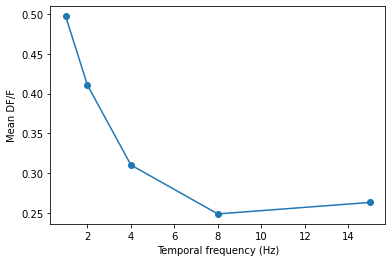

In [ ]:
plt.plot(tfvals, tuning_tf, 'o-')
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Mean DF/F")

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
Compare these curves with the plots we made above of all the trials. What do we see now?
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 4:** Add errorbars to the above tuning curves. They can be standard deviation or standard error or the mean. Make a new array for the tuning values with two columns - one for the mean response and one for the error you decide to use
    
<p>(Hint: for plotting, <b>plt.errorbar</b> will be useful).
</div>

In [ ]:
tuning = np.empty((8,2))
for i, ori in enumerate(orivals):
    trials = cell_response[:,0]==ori
    tuning[i,0] = cell_response[trials,2].mean()
    tuning[i,1] = cell_response[trials,2].std()

<ErrorbarContainer object of 3 artists>

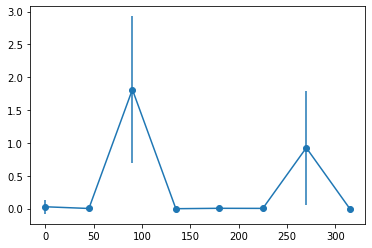

In [ ]:
plt.errorbar(orivals, tuning[:,0], yerr=tuning[:,1], fmt='o-')

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
**Exercise 5:** Add a black line showing the mean response to the blank sweep.
<br>(Hint 1: orientation and temporal frequency are NaN for the blank sweep condition.  Hint 2: <b>plt.axhline</b> is a useful function for adding a horizontal line).  </div>

In [ ]:
blank_trials = np.isnan(cell_response[:,0])
blank_mean = cell_response[blank_trials,2].mean()
print(blank_mean)

0.019221892748991477


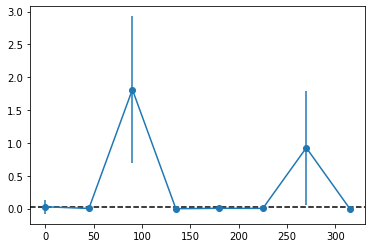

In [ ]:
plt.errorbar(orivals, tuning[:,0], yerr=tuning[:,1], fmt='o-')
plt.axhline(y=blank_mean, ls='--', color='k')

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
Why is it important to add these two features?
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
**Exercise 6:** Add the errorbars and blank sweep response to the temporal frequency plot as well </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>So far we've looked at one stimulus dimension (e.g. orientation) averaged across all conditions of the other (e.g. temporal frequency) - and vice versa. Now we want to look at these tuning curves for both dimensions.
<p>To begin, let's compute the two-dimensional tuning array for this neuron - computing the mean response for every possible orientation and temporal frequency combination.
</div>

What is the shape of the array we will be computing?

In [ ]:
tuning_array = np.empty((8,5))
for i,tf in enumerate(tfvals):
    tf_trials = cell_response[:,1]==tf
    subset = cell_response[tf_trials]
    for j,ori in enumerate(orivals):
        trials = subset[:,0]==ori
        tuning_array[j,i] = subset[trials,2].mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>Let's start by visualizing this similarly to how we did above: Plot the orientation tuning curve for each temporal frequency value as a separate line:
</div>

Text(0, 0.5, 'Mean DF/F')

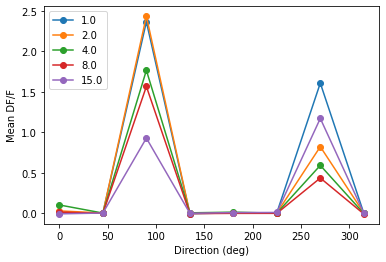

In [ ]:
for i, tf in enumerate(tfvals):
    plt.plot(orivals, tuning_array[:,i], 'o-', label=tf)
plt.legend()
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
**Exercise 7:** Plot each temporal frequency tuning curve for each orientation as a separate line. </div>

Text(0, 0.5, 'Mean DF/F')

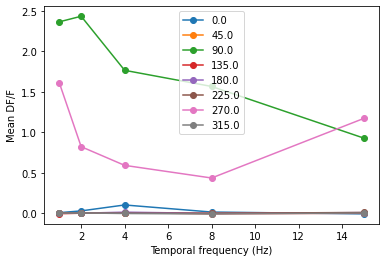

In [ ]:
for i, ori in enumerate(orivals):
    plt.plot(tfvals, tuning_array[i,:], 'o-', label=ori)
plt.legend()
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Mean DF/F")

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
What do we see now?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>Another way to visualize two dimensional data is as a heatmap. Let's use <b>plt.imshow</b> to create this heatmap.</div>

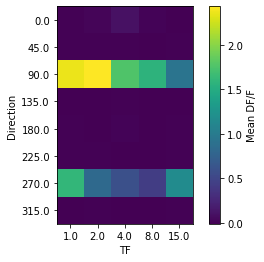

In [ ]:
plt.imshow(tuning_array)
plt.xticks(range(5), tfvals)
plt.yticks(range(8), orivals)
plt.xlabel("TF")
plt.ylabel("Direction")
cbar = plt.colorbar() #Add the colorbar so we know what the colors mean
cbar.set_label("Mean DF/F")

Let's save this figure to the results folder!

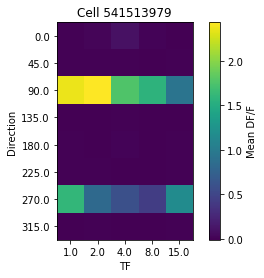

In [ ]:
plt.imshow(tuning_array)
plt.xticks(range(5), tfvals)
plt.yticks(range(8), orivals)
plt.xlabel("TF")
plt.ylabel("Direction")
cbar = plt.colorbar() #Add the colorbar so we know what the colors mean
cbar.set_label("Mean DF/F")
plt.title("Cell "+str(cell_id)) #Add a title so we know what the plot is of
plt.savefig("/results/Cell "+str(cell_id)+".jpg") #save the figure

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>This visualization gives us a great view of how the two dimensions interact, but one disadvantage is that we can't add errorbars or even the blank sweep response to this. But we saw that that information can be important for interpreting what we see in the data.
<p>One approach we can take is to compute the <b>z score</b> where each response is mean subtracted and normalized to the standard deviation. So it shows how far each response deviates from the mean response (rather than the blanksweep response as we plotted above in exercise 5).
</div>

In [ ]:
tuning_array_z = (tuning_array - tuning_array.mean())/tuning_array.std()

Text(0.5, 1.0, 'Cell 541513979')

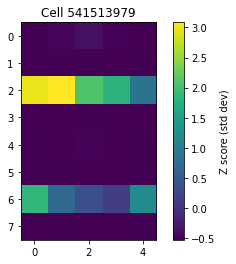

In [ ]:
plt.imshow(tuning_array_z)
cbar = plt.colorbar() #Add the colorbar so we know what the colors mean
cbar.set_label("Z score (std dev)")
plt.title("Cell "+str(cell_id)) #Add a title so we know what the plot is of